step 19: all PSG features are concatenated and standatrized without artifacts. Furthermore, PCA with 50 components and K-Means clustering are applied. The distribution of K-Means clusters are stored in csv file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter as counter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
sns.set()
no_subject = 27 # number of subjects
no_channel = 8 # number of channels
n_cluster = 4

file_path = './PSG_features/' # features files path
data = pd.read_csv('PSG_features_8chn.csv') # features files names
file_name = data['fname']

shape of one subject having 8 channels: (954, 200)


0.22782250104950078

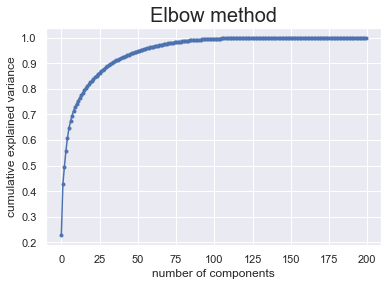

In [3]:
sub_len = pd.read_csv(file_path+file_name[0]).shape # features data shape
data_con = np.empty((sub_len[0],0)) # array for merging the PSG channels (subject) per night
column = np.empty((0))
for nchn in range(no_channel):
    df_feature = pd.read_csv(file_path+file_name[nchn])
    # for EEG channels
    if 'alpha_mean' in df_feature.columns:
        df_feat = df_feature.drop(df_feature[['flag', 'alpha_mean', 'theta_mean', 'delta_mean', 'label']], axis=1) # removing columns from EEG channels
        column = np.append(column, df_feat.columns)
    # for other PSG channels
    else:
        df_feat = df_feature.drop(df_feature[['flag', 'label']], axis=1) # removing columns from other PSG channels
        column = np.append(column, df_feat.columns)
    data_con = np.concatenate((data_con, df_feat), axis=1)
    
df = pd.DataFrame(data = data_con, columns=column)
print('shape of one subject having 8 channels: {}' .format(df.shape))

df['flag'] = pd.read_csv(file_path+file_name[0])['flag'] 
df_feat = df[df['flag'] == 0] # removing atrifacts by single PSG channel's flag
X = df_feat.drop(['flag'], axis=1)
X_scalar = StandardScaler().fit_transform(X)
X_pca = PCA()
X_pca.fit_transform(X_scalar)

plt.plot(np.cumsum(X_pca.explained_variance_ratio_), '.-')
plt.title('Elbow method', fontsize=20)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.max(X_pca.explained_variance_ratio_)

Text(0, 0.5, 'within-cluster sum-of-squares')

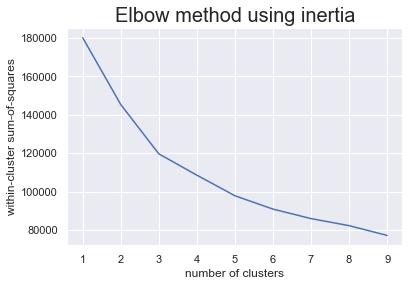

In [4]:
X_pca = PCA(n_components=50).fit_transform(X_scalar)
distance = []
for i in range(1,10):
    kmeans_ = KMeans(i)
    kmeans_.fit(X_pca)
    distance.append(kmeans_.inertia_)
    
%matplotlib inline
plt.plot(np.arange(1,10), distance)
plt.title('Elbow method using inertia', fontsize=20)
plt.xlabel('number of clusters')
plt.ylabel('within-cluster sum-of-squares')

In [5]:
nfile = 0 # counter for the PSG file selecting
file_sel = 0 # counter for assigning the shape of an array
flag_col = -1 # counter of selection of feature file for artifact removing (flag)
dist_array = np.empty((0, n_cluster)) 

for nsub in range(no_subject):
    sub_len = pd.read_csv(file_path+file_name[file_sel]).shape
    data_con = np.empty((sub_len[0],0))
    
    column = np.empty((0))
    file_sel += no_channel
    flag_col += no_channel
    
    for nchn in range(no_channel):
        df_feature = pd.read_csv(file_path+file_name[nfile])
        
        if 'alpha_mean' in df_feature.columns:
            df_feat = df_feature.drop(df_feature[['flag', 'alpha_mean', 'theta_mean', 'delta_mean', 'label']], axis=1) # removing columns from EEG channels
            column = np.append(column, df_feat.columns)
            
        else:
            df_feat = df_feature.drop(df_feature[['flag', 'label', 'mean']], axis=1) # removing columns from other PSG channels
            column = np.append(column, df_feat.columns)
            
        data_con = np.concatenate((data_con, df_feat), axis=1)
        nfile += 1

    df = pd.DataFrame(data = data_con, columns=column)
    df['flag'] = pd.read_csv(file_path+file_name[flag_col])['flag']
    df_feat = df[df['flag'] == 0]
    df_feat = df_feat.drop(['flag'], axis=1)
    
    X_scalar = StandardScaler().fit_transform(df_feat)
    X_pca = PCA(n_components=55).fit_transform(X_scalar)
    model = KMeans(n_clusters=n_cluster, random_state=1).fit(X_pca)
    # aggregating the cluster by count
    dist = pd.crosstab(index='counts', columns=model.labels_)
    dist_array = np.concatenate((dist_array, dist), axis=0)
    
df_dist = pd.DataFrame(data=dist_array, columns=['cluster1', 'cluster2', 'cluster3', 'cluster4'])# , 'cluster5'])#, 'cluster6'])

In [6]:
# calculating the cluster's proportion

dist_prop = np.empty((0, n_cluster))

for i in range(no_subject):
    dist_int = np.empty((0))
    dist_sum = np.sum(df_dist.iloc[i,:])
    
    for j in range(n_cluster):
        proportion = (df_dist.iloc[i,j]/dist_sum)*100
        dist_int = np.append(dist_int, [proportion], axis=0)

    dist_prop = np.append(dist_prop, [dist_int], axis=0)

In [7]:
# creating the dataframe of clusters, their proportion and true labels 
df_psg = pd.read_csv('PSG_dataset.csv') # for label and file
df_dist['clust1_proportion(%)'] = dist_prop[:,0]
df_dist['clust2_proportion(%)'] = dist_prop[:,1]
df_dist['clust3_proportion(%)'] = dist_prop[:,2]
df_dist['clust4_proportion(%)'] = dist_prop[:,3]
#df_dist['clust4_proportion(%)'] = dist_prop[:,4]
df_dist[['fname', 'label']] = df_psg[['fname', 'label']]
#df_dist.to_csv('./PSG8_5_Clustering(55PC).csv', index=False)
df_dist.head(10)

cluster1  cluster2  cluster3  cluster4  clust1_proportion(%)  \
0     364.0     179.0     337.0      56.0             38.888889   
1     143.0     257.0      90.0     462.0             15.021008   
2     331.0     533.0      83.0      52.0             33.133133   
3     123.0     235.0     521.0      24.0             13.621262   
4     615.0     140.0     267.0      38.0             58.018868   
5     481.0     205.0     124.0      24.0             57.673861   
6     444.0     214.0      80.0     230.0             45.867769   
7     215.0     346.0      51.0     197.0             26.576020   
8     477.0     184.0     399.0      53.0             42.857143   
9     338.0      46.0     350.0     273.0             33.565045   

   clust2_proportion(%)  clust3_proportion(%)  clust4_proportion(%)  \
0             19.123932             36.004274              5.982906   
1             26.995798              9.453782             48.529412   
2             53.353353              8.308308              5.205205   
3             26.024363             57.696567              2.657807   
4             13.207547             25.188679              3.584906   
5             24.580336             14.868106              2.877698   
6             22.107438              8.264463             23.760331   
7             42.768850              6.304079             24.351051   
8             16.531896             35.849057              4.761905   
9              4.568024             34.756703             27.110228   

          fname  label  
0  A0000724.edf      0  
1  A0000737.edf      0  
2  A0000773.edf      0  
3  A0000934.edf      1  
4  A0000960.edf      1  
5  A0001023.edf      1  
6  A0000949.edf      0  
7  A0000983.edf      0  
8  A0002042.edf      0  
9  A0001983.edf      1

The below analysis has done for the clusters pattern with their time series statistics (features).

In [42]:
no_channel = 8 # number of channels
n_cluster = 4

sub_len = pd.read_csv(file_path+file_name[8]).shape # features data shape
data_con = np.empty((sub_len[0],0)) # array for merging the PSG channels (subject) per night
column = np.empty((0))
for nchn in range(no_channel):
    df_feature = pd.read_csv(file_path+file_name[nchn+8])
    # for EEG channels
    if 'alpha_mean' in df_feature.columns:
        df_feat = df_feature.drop(df_feature[['flag', 'alpha_mean', 'theta_mean', 'delta_mean', 'label']], axis=1) # removing columns from EEG channels
        column = np.append(column, df_feat.columns)
    # for other PSG channels
    else:
        df_feat = df_feature.drop(df_feature[['flag', 'mean', 'label']], axis=1) # removing columns from other PSG channels
        column = np.append(column, df_feat.columns)
    data_con = np.concatenate((data_con, df_feat), axis=1)
    
df = pd.DataFrame(data = data_con, columns=column)
print('shape of one subject having 8 channels: {}' .format(df.shape))

df['flag'] = pd.read_csv(file_path+file_name[8])['flag']
df_feat = df[df['flag'] == 0]
X = df_feat.drop(['flag'], axis=1)
X_scalar = StandardScaler().fit_transform(df_feat)
X_pca = PCA(n_components=50).fit_transform(X_scalar)
model = KMeans(n_clusters=n_cluster, random_state=1).fit(X_pca)


shape of one subject having 8 channels: (982, 198)


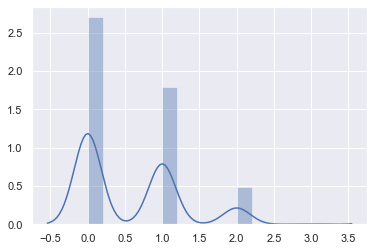

In [43]:
cluster_label = pd.DataFrame(model.labels_, columns=['predict'])
df_feature = pd.read_csv(file_path+file_name[0])
df_feature = df_feature[df_feature['flag'] == 0]
theta_ent = df_feature['theta_entropy']
alpha_kurt = df_feature['alpha_Kurtosis']
sns.distplot(cluster_label)

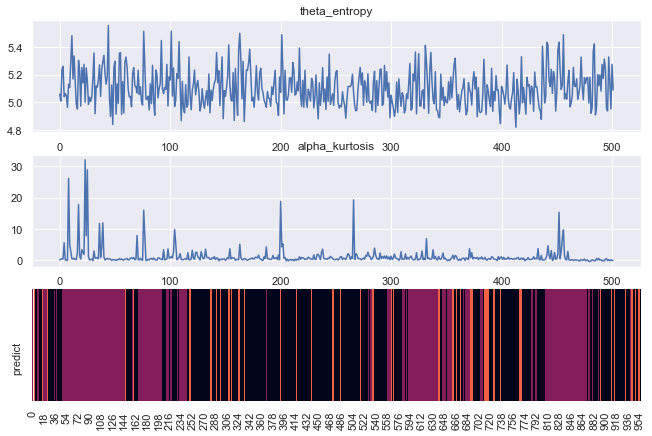

In [46]:
plt.figure(figsize=(24,7))
plt.subplot((321))
plt.plot(theta_ent[0:500])
plt.title('theta_entropy')
plt.subplot((323))
plt.plot(alpha_kurt[0:500])
plt.title('alpha_kurtosis')
plt.subplot((325))
sns.heatmap(cluster_label.T, cbar=False)
plt.show()

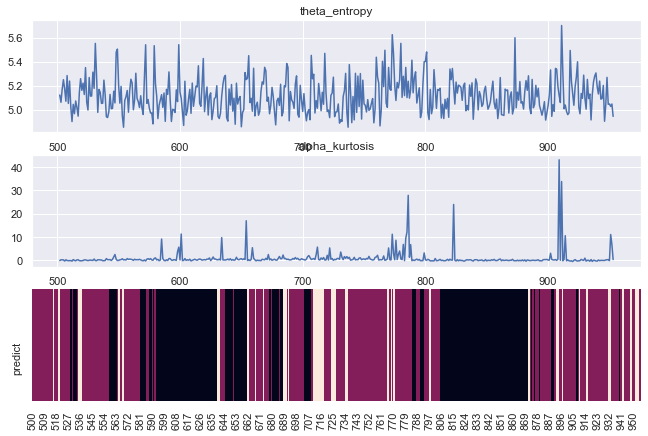

In [41]:
plt.figure(figsize=(24,7))
plt.subplot((321))
plt.plot(theta_ent[500:])
plt.title('theta_entropy')
plt.subplot((323))
plt.plot(alpha_kurt[500:])
plt.title('alpha_kurtosis')
plt.subplot((325))
sns.heatmap(cluster_label[500:].T, cbar=False)
plt.show()